# PRACTICA GUIADA: KNN

## Introducción

En esta práctica vamos utilizar KNN para resolver un problema de clasificación.

Vamos a realizar los siguientes pasos:

1. Cargar el dataset
2. Preparar la matriz de features y el vector de targets
3. Elegir el valor óptimo para el hiperparámetro n_neighbours utilizando validación cruzada
4. Repetir el proceso pero estandarizando la matriz de features para ver los efectos sobre el algoritmo 
5. Graficar la matriz de confusión

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

## 1 - Cargar el dataset

In [2]:
# Cargamos el dataset y visualizamos su descripción
cancer = load_breast_cancer()
print(cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

## 2 - Construimos la matriz de features y el vector de targets

In [3]:
# Construimos la matriz de features y visualizamos las primeras filas
X = pd.DataFrame(cancer.data, columns = cancer.feature_names)
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
# Construimos el vector target y visualizamos las primeras filas
y = pd.Series(cancer.target)
y.sample(10)

141    0
462    1
389    0
16     0
110    1
182    0
252    0
412    1
117    0
486    1
dtype: int32

In [5]:
pd.Series(y).value_counts(normalize=True)

1    0.627417
0    0.372583
dtype: float64

#### Train Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=12)

## 3 - Evaluamos distintos valores para el hiperparámetro

Ahora vamos a ejecutar el modelo KNeighborsClassifier probando distintos valores posibles para el hiperparámetro n_neighbors.

In [7]:
# Vamos a querer graficar los distintos valores del score de cross validation
# en función del hiperparámetro n_neighbors. Para esto generamos una lista de
# diccionarios que después se puede convertir fácilmente en DataFrame.

# Probamos todos los enteros desde el 1 hasta el 20
# como posibles valores de n_neighbors a explorar.

kf = KFold(n_splits=5, shuffle=True, random_state=12)

scores_para_df = []

for i in range(1, 21):
    
    # En cada iteración instanciamos el modelo con un hiperparámetro distinto
    model = KNeighborsClassifier(n_neighbors=i)
    
    # cross_val_scores nos devuelve un array de 5 resultados,
    # uno por cada partición que hizo automáticamente CV
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf)
    
    # Para cada valor de n_neighbours, creo un diccionario con el valor
    # de n_neighbours y la media y el desvío de los scores.
    dict_row_score = {'score_medio':np.mean(cv_scores),\
                      'score_std':np.std(cv_scores), 'n_neighbours':i}
    
    # Guardo cada uno en la lista de diccionarios
    scores_para_df.append(dict_row_score)

In [8]:
# Creamos el DataFrame a partir de la lista de diccionarios
df_scores = pd.DataFrame(scores_para_df)
df_scores.head()

,n_neighbours,score_medio,score_std
0,1,0.906074,0.026914
1,2,0.903721,0.029294
2,3,0.915513,0.027165
3,4,0.903721,0.029294
4,5,0.910780,0.032984


#### Graficando la búsqueda del mejor hiperparámetro

El valor de scoring que utiliza por defecto KNeighborsClassifier es el accuracy: el % de casos bien clasificados. 

Una vez que tenemos el DataFrame con la performance para cada valor del hiperparámetro hacemos un gráfico con los valores. Para darnos una idea de la dispersión vamos a graficar también las líneas que indican un desvío estándar por encima y por debajo de la media. 

In [9]:
df_scores['limite_inferior'] = df_scores['score_medio'] - df_scores['score_std']
df_scores['limite_superior'] = df_scores['score_medio'] + df_scores['score_std']
df_scores.head()

,n_neighbours,score_medio,score_std,limite_inferior,limite_superior
0,1,0.906074,0.026914,0.879160,0.932988
1,2,0.903721,0.029294,0.874427,0.933015
2,3,0.915513,0.027165,0.888348,0.942678
3,4,0.903721,0.029294,0.874427,0.933015
4,5,0.910780,0.032984,0.877795,0.943764


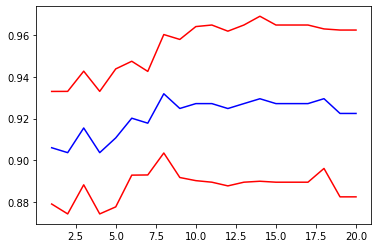

In [10]:
plt.plot(df_scores['n_neighbours'],df_scores['limite_inferior'],color='r')
plt.plot(df_scores['n_neighbours'],df_scores['score_medio'],color='b')
plt.plot(df_scores['n_neighbours'],df_scores['limite_superior'],color='r');

In [11]:
df_scores.loc[df_scores.score_medio == df_scores.score_medio.max()]

,n_neighbours,score_medio,score_std,limite_inferior,limite_superior
7,8,0.931874,0.028318,0.903556,0.960192


## 4 - Estandarización de las variables

Dijimos que KNN es un método de Machine Learning que se basa en medidas de distancia. Lo correcto es estandarizar las variables para eliminar las distintas unidades de medida y evitar distorsiones debidas a distintas escalas.

In [12]:
# Utilizamos sklearn para estandarizar la matriz de features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [13]:
# Verificamos que las columnas tengan media 0 y desvío 1.
print('media:',np.mean(X_train[:,1]))
print('desvio:',np.std(X_train[:,1]))

media: -9.49683732801425e-16
desvio: 0.9999999999999999


In [14]:
# Calculamos nuevamente los scores de cross validation,
# pero esta vez sobre los features estandarizados:

scores_para_df_standar = []

for i in range(1, 21):
    model = KNeighborsClassifier(n_neighbors=i)
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf)
    dict_row_score = {'score_medio':np.mean(cv_scores),\
                      'score_std':np.std(cv_scores),'n_neighbours':i}
    scores_para_df_standar.append(dict_row_score)

In [15]:
df_scores_standar = pd.DataFrame(scores_para_df_standar)
df_scores_standar.head()

,n_neighbours,score_medio,score_std
0,1,0.957729,0.015996
1,2,0.950643,0.020311
2,3,0.960082,0.012031
3,4,0.964788,0.007442
4,5,0.962462,0.008689


In [16]:
# Armamos nuevamente los límites para graficar

df_scores_standar['limite_superior'] = df_scores_standar['score_medio'] + df_scores_standar['score_std']
df_scores_standar['limite_inferior'] = df_scores_standar['score_medio'] - df_scores_standar['score_std']
df_scores_standar.head()

,n_neighbours,score_medio,score_std,limite_superior,limite_inferior
0,1,0.957729,0.015996,0.973725,0.941734
1,2,0.950643,0.020311,0.970954,0.930332
2,3,0.960082,0.012031,0.972113,0.948051
3,4,0.964788,0.007442,0.972230,0.957345
4,5,0.962462,0.008689,0.971151,0.953774


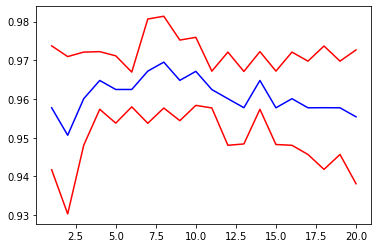

In [17]:
# Buscamos gráficamente el valor ópitmo para n_neighbors

plt.plot(df_scores_standar['n_neighbours'],df_scores_standar['limite_inferior'],color='r')
plt.plot(df_scores_standar['n_neighbours'],df_scores_standar['score_medio'],color='b')
plt.plot(df_scores_standar['n_neighbours'],df_scores_standar['limite_superior'],color='r');

In [18]:
df_scores_standar.loc[df_scores_standar.score_medio == df_scores_standar.score_medio.max()]

,n_neighbours,score_medio,score_std,limite_superior,limite_inferior
7,8,0.969521,0.011849,0.98137,0.957673


In [19]:
best_k = df_scores_standar.loc[df_scores_standar.score_medio ==\
                               df_scores_standar.score_medio.max(),'n_neighbours'].values
best_k = best_k[0]
best_k

8

## 5 - Matriz de confusión

Ahora que decidimos cuál es el mejor preprocesamiento y el mejor valor posible para el hiperparámetro n_neighbors, podemos calcular la matriz de confusión sobre datos no utilizados en la selección del hiper parámetro.

In [20]:
# Elegimos el modelo óptimo que nos había indicado cross validation
model = KNeighborsClassifier(n_neighbors=best_k)

# Lo ajustamos sobre datos de entrenamiento
model.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                     weights='uniform')

In [21]:
# Lo utilizamos para predecir en test
X_test = scaler.transform(X_test) # ¡Importantísimo estandarizar también los datos de test!
y_pred = model.predict(X_test)

In [22]:
# Obtenemos la matriz de confusión
confusion_matrix(y_test, y_pred)

array([[50,  3],
       [ 3, 87]], dtype=int64)

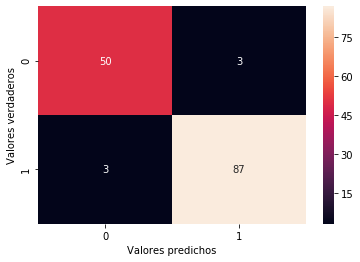

In [23]:
# Graficamos la matriz de confusión para visualizarla mejor
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.ylabel('Valores verdaderos')
plt.xlabel('Valores predichos');

In [24]:
# Podemos calcular manualmente la exactitud de nuestro modelo...

(50 + 87) / len(y_pred)

0.958041958041958

In [25]:
# ... o computarla utilizando el método del accuracy score

accuracy_score(y_test, y_pred)

0.958041958041958

## Conclusión

Pese a ser un modelo de los más sencillos, aplicando KNN sobre el dataset de cáncer de mama, podemos distinguir con un 96% de exactitud los tumores benignos de los malignos. 